# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm

In [3]:
omega, A, C = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=0.69)

In [4]:
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [5]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048*2)

t0 = 0.25

fit = qnm_filter.Network(**input)
massspace = np.arange(25, 75, 0.5)
chispace = np.arange(0.0, 0.95, 0.05)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

(0.25, 0.26)

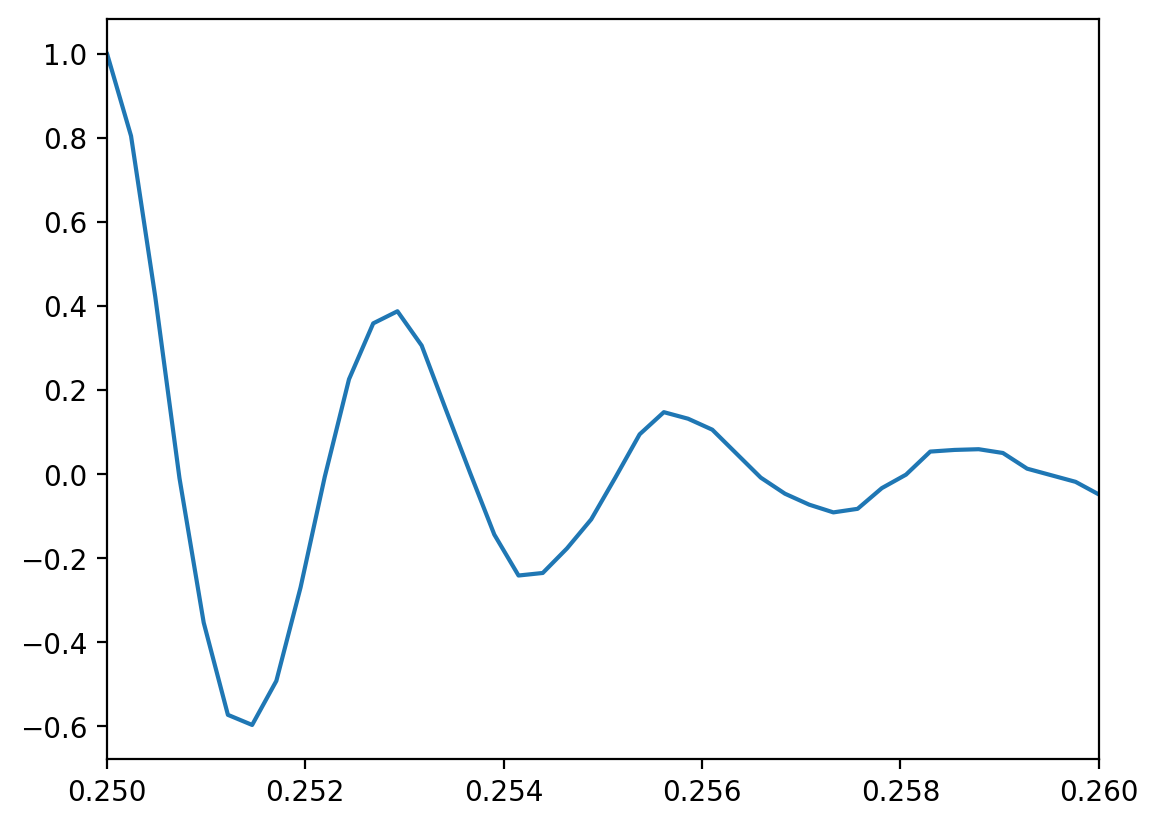

In [6]:
srate = input['srate']
t_range_prepad = np.linspace(0,0.5, int(srate/2), endpoint = False)
heaviside = np.heaviside(t_range_prepad, 1)
temp = np.exp(-1j*omega*t_range_prepad/(50*T_MSUN))
signal_prepad = np.real(temp*heaviside)
t_range = np.linspace(0,1, srate, endpoint = False)
signal = np.pad(signal_prepad, (int(srate/4),int(srate/4)))
noise = np.random.normal(0,0.01,srate)

data = signal + noise
pl.plot(t_range, data)
pl.xlim(0.25, 0.26)

In [7]:
temp = qnm_filter.Network(**input)
temp.original_data["inj"] = qnm_filter.Data(data, index = t_range, ifo = "inj")
temp.start_times['inj'] = input['t_init']
temp.pure_noise = {}
temp.pure_noise['inj'] = qnm_filter.Data(noise, index = t_range, ifo = "inj")
temp.condition_data('original_data', trim_length = 0.0, **input)
temp.compute_acfs('pure_noise')

In [8]:
acf_test = temp.acfs['inj']*0
acf_test[0] = 0.01**2
temp.acfs['inj'] = acf_test
temp.cholesky_decomposition()

In [9]:
time_array = np.linspace(0.23, 0.27, 20)
evidence_array = [temp.t_init_evidence(i, massspace, chispace, num_cpus = -1, **input) for i in time_array]

Text(0.5, 1.0, 'Evidence vs time for 220 injections')

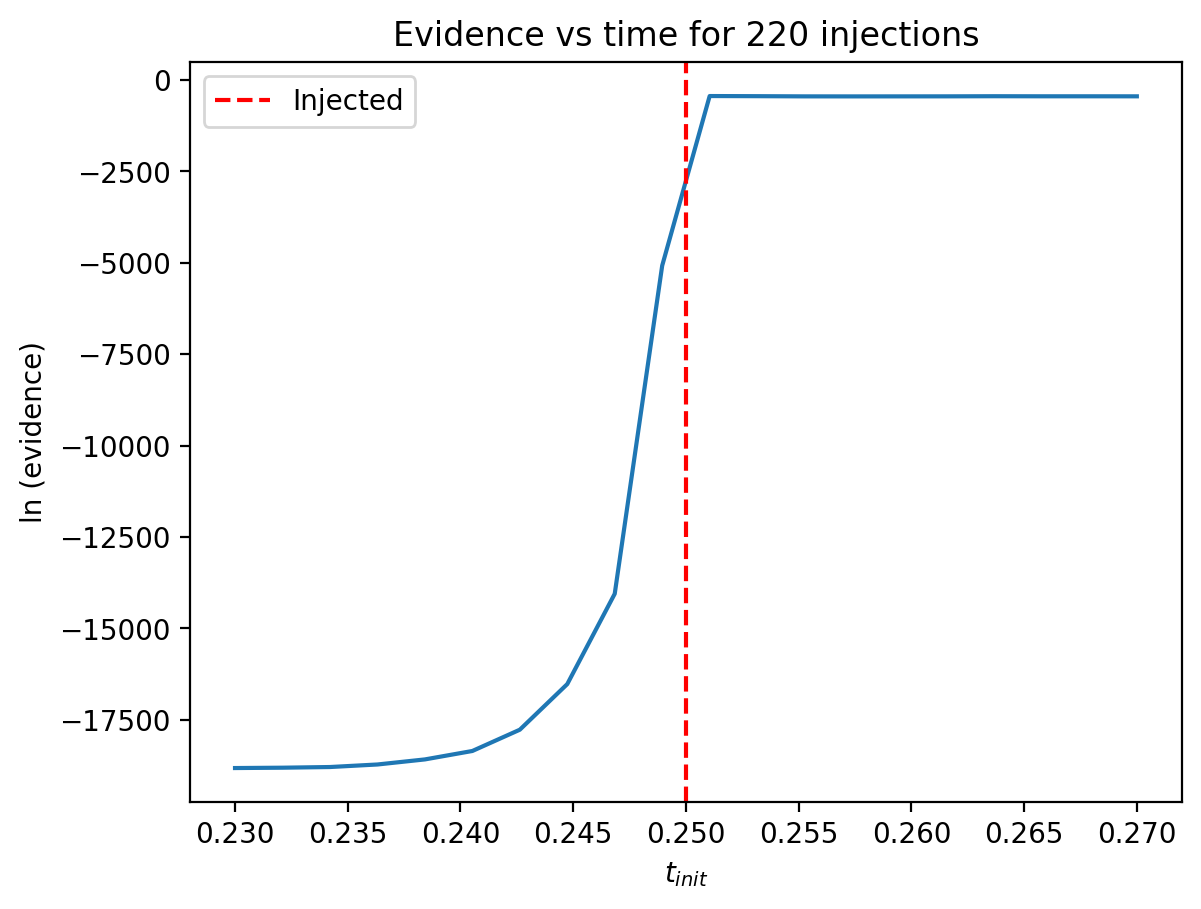

In [10]:
mass = 50
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

pl.plot(time_array, evidence_array)
pl.axvline(0.25, c = 'r', ls = '--', label = "Injected")
pl.legend()
pl.xlabel(r'$t_{init}$')
pl.ylabel(r'ln (evidence)')
pl.title("Evidence vs time for 220 injections")